In [39]:
# Time spent on assignment: 25 hours

import numdifftools as nd
import numpy as np
import matplotlib as mpl
np.set_printoptions(precision=3, suppress=True)
%load_ext autoreload
%autoreload 2
# %matplotlib inline
# %config InlineBackend.print_figure_kwargs = {'bbox_inches':None}




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2. Make a function for generating the derivative in the direction of a function at a given point.
Deliverables:
- Replicate the Cartesian-expressed polar vector fields in Fig. 2.7 and Example 2.3.1 using your direction-derivative code.
- Demonstrate that you can equivalently create the vector fields by using the numerical Jacobian of a function F to map a single generating vector out to points on the field.

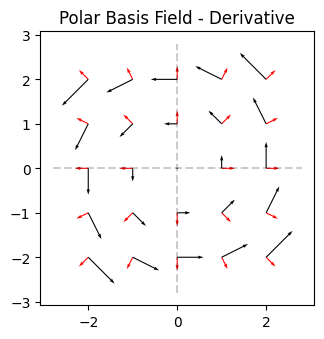

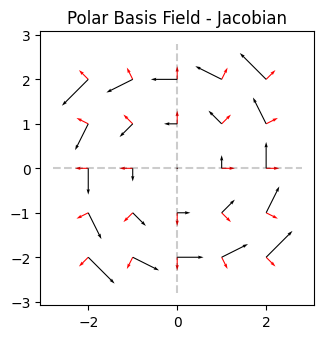

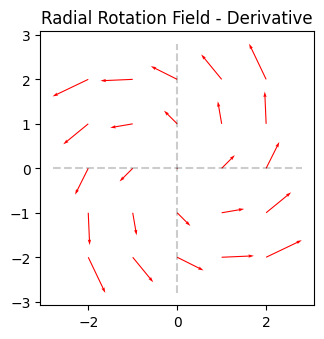

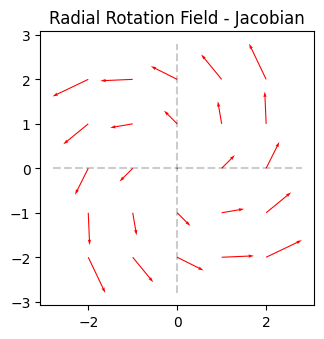

In [40]:
from deriv_utils import compute_jacobian, derivative_in_direction
from plotter import plot_vector_field
from vector import VectorBases

def radial(config, delta = 0):
    x, y = config
    r = np.sqrt(x**2 + y**2)
    if isinstance(delta,np.ndarray):
        delta = delta.flatten()[0]
    rho = float(delta)
    # eq 2.49
    radial_factor = (1. + rho / r) if not np.isclose(r, 0.) else 1
    polar = radial_factor * config.reshape(2,1)
    return polar.reshape(config.shape)

def rotation(config, delta = 0):
    if isinstance(delta,np.ndarray):
        delta = delta.flatten()[0]
    phi = float(delta)
    # eq 2.48
    rotation_factor = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
    polar = rotation_factor @ config.reshape(2,1)
    return polar

def radial_rotation(config, delta = 0):
    if isinstance(delta,np.ndarray):
        delta = delta.flatten()[0]
    phi_rho = delta * np.array([1., 1.]).reshape(2, 1)
    x, y = config
    # eq 2.52
    r = np.sqrt(x**2 + y**2)
    rinv = 1 / r if not np.isclose(r, 0.) else 1
    diff_rho = np.array([x * rinv, y * rinv]).reshape(2, 1)
    diff_phi = np.array([-y, x]).reshape(2, 1)
    radial_rotation = np.hstack([diff_phi, diff_rho]) @ phi_rho
    return radial_rotation.reshape(config.shape)

# f -> generate, F -> transform
# F (f (x)) = f (F (x))
# F ( q' ) = p'
x = y = np.linspace(-2, 2, 5)
X, Y = np.meshgrid(x, y)
configuration = np.vstack((X.ravel(), Y.ravel())).T
radial_derivs = [derivative_in_direction(radial, config.reshape(2,)) for config in configuration]
rotation_derivs = [derivative_in_direction(rotation, config.reshape(2,)) for config in configuration]
vb = VectorBases(radial_derivs)
vb2 = VectorBases(rotation_derivs)
plot_vector_field(vb.configs(), [vb.flatten(), vb2.flatten()], title="Polar Basis Field - Derivative")


# nudge the input space, how much does the output space change?
radial_jacob = np.stack([compute_jacobian(radial, config.reshape(2,)) for config in configuration])
rotation_jacob = np.stack([compute_jacobian(rotation, config.reshape(2,)) for config in configuration])
vb = VectorBases(radial_jacob)
vb2 = VectorBases(rotation_jacob)
plot_vector_field(vb.configs(), [vb.flatten(), vb2.flatten()], title="Polar Basis Field - Jacobian")

radial_rotation_derivs = [derivative_in_direction(radial_rotation, config.reshape(2,)) for config in configuration]
vb = VectorBases(radial_rotation_derivs)
plot_vector_field(vb.configs(), [vb.flatten()], title="Radial Rotation Field - Derivative")

radial_rotation_jacob = np.stack([compute_jacobian(radial_rotation, config.reshape(2,)) for config in configuration])
vb = VectorBases(radial_rotation_jacob)
plot_vector_field(vb.configs(), [vb.flatten()], title="Radial Rotation Field - Jacobian")

3. Make a “group tangent vector” class that stores the location of the vector as a group element instead of a simple list of coordinate values


Deliverables: Replicate the groupwise vector basis fields in Fig. 2.10 b and c, using your direction-derivative function with the group actions of elements that are δ away from the identity in single components.

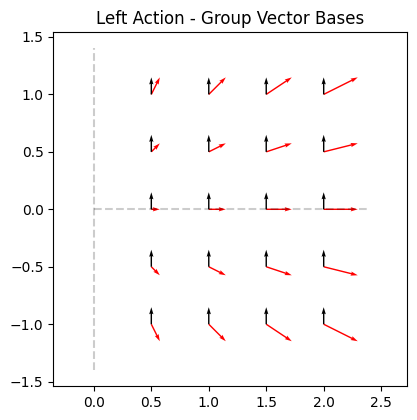

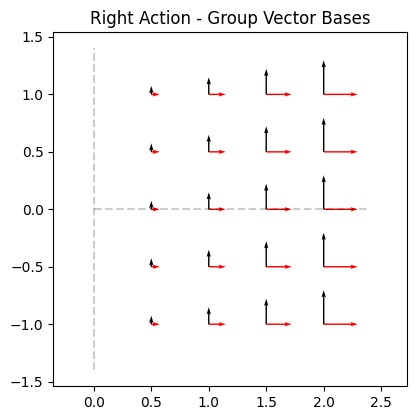

In [41]:
from repgroup import SemiDirectProduct, RepGroupElement
from lie_algebra import GroupVectorBases

x = np.linspace(0.5, 2, 4)
y = np.linspace(-1, 1, 5)
X, Y = np.meshgrid(x, y)
configuration = np.vstack((X.ravel(), Y.ravel())).T
sdp = SemiDirectProduct()
group_vectors = [RepGroupElement(value=config, group=sdp) for config in configuration]

group_vb = GroupVectorBases(group_vectors)
res_left = group_vb.evaluate(sdp.identity_element(), "left")
plot_vector_field(res_left[0].configs(), [res.flatten() for res in res_left], title='Left Action - Group Vector Bases')
res_right = group_vb.evaluate(sdp.identity_element(), "right")
plot_vector_field(res_right[0].configs(), [res.flatten() for res in res_right], title='Right Action - Group Vector Bases')


Extend your group element class so that it has left and right lifted actions that act on vectors.
These lifted actions should be generated automatically from the group action using numerical differentiation tools, and their outputs should return group tangent vectors anchored at the new location. Also provide an adjoint action (named Ad) on vectors, which combines the left
and right lifted actions.
Deliverables:
 - Replicate the groupwise vector basis fields in Fig. 2.10 b and c, using lifted actions to
transfer unit-coefficient vectors at the identity out to each point.
 - Find the scale-shift vector adjoint to g = [1 1/2].T at g = ( 1/2, −1), and make a set of plots similar to Fig. 2 11 demonstrating this adjoint relationship

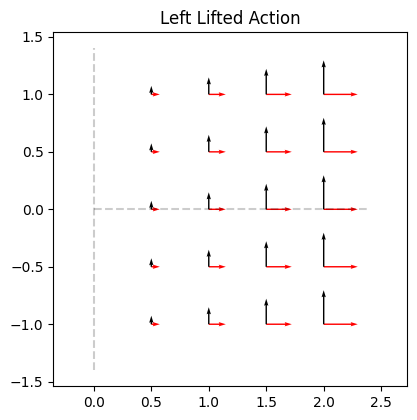

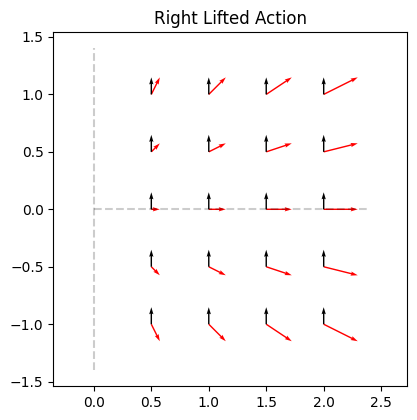

In [48]:
from lie_algebra import LieGroup
from repgroup import SemiDirectProduct
sdplie = LieGroup(SemiDirectProduct.sd_repr, SemiDirectProduct.sd_derepr, np.eye(2))
group_vectors = [sdplie.element(value=config.reshape(2, )) for config in configuration]

dx = sdplie.element(np.array([1, 0]))
dy = sdplie.element(np.array([0, 1]))
vbs_l = VectorBases([sdplie.eval_left_lifted_action(config, sdplie.identity_element(), dx) for config in group_vectors])
vbs_r = VectorBases([sdplie.eval_left_lifted_action(config, sdplie.identity_element(), dy) for config in group_vectors])
plot_vector_field(configuration.T, [vbs_l.flatten(), vbs_r.flatten()], title="Left Lifted Action")

vbs_l = VectorBases([sdplie.eval_right_lifted_action(config, sdplie.identity_element(), dx) for config in group_vectors])
vbs_r = VectorBases([sdplie.eval_right_lifted_action(config, sdplie.identity_element(), dy) for config in group_vectors])
plot_vector_field(configuration.T, [vbs_l.flatten(), vbs_r.flatten()], title="Right Lifted Action")

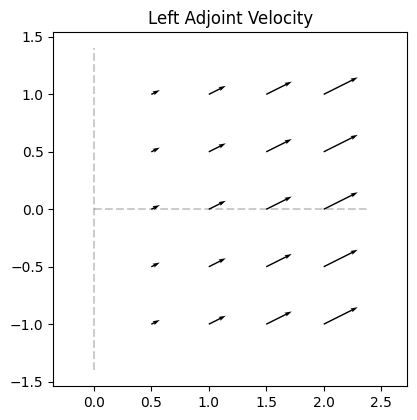

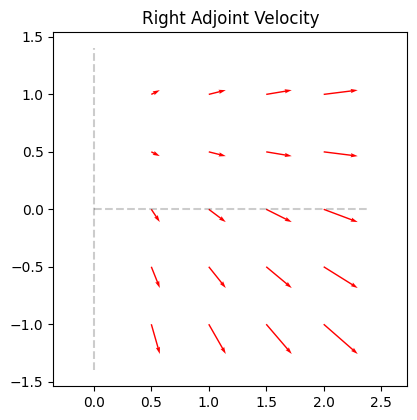

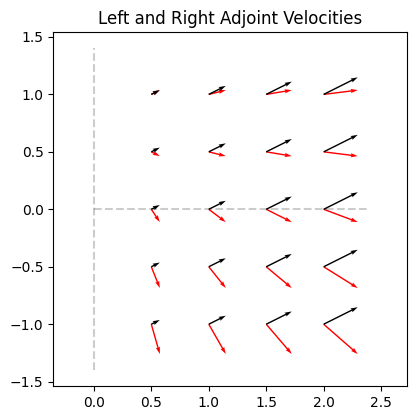

In [50]:
# verifying adjoint
# gleftcirc = sdplie.element(value=np.array([1, -0.25]))
# grightcirc = sdplie.element(value=np.array([1, 0.5]))

# g = sdplie.element(value=np.array([3/2, 1]))
# print(gleftcirc == g.ad(grightcirc))
# print(grightcirc == g.ad_inv(gleftcirc))

grightcirc = sdplie.element(value=np.array([1, 0.5]))
g = sdplie.element(value=np.array([1/2, 1]))
gleftcirc = g.ad(grightcirc)

left_velocities = [sdplie.eval_left_lifted_action(config, g, grightcirc) for config in group_vectors]
right_velocities = [sdplie.eval_right_lifted_action(config, g, gleftcirc) for config in group_vectors]
vbs_l = VectorBases(left_velocities)
vbs_r = VectorBases(right_velocities)
plot_vector_field(configuration.T, [vbs_l.flatten()], title="Left Adjoint Velocity", color_idx=1)
plot_vector_field(configuration.T, [vbs_r.flatten()], title="Right Adjoint Velocity")
plot_vector_field(configuration.T, [vbs_r.flatten(), vbs_l.flatten()], title="Left and Right Adjoint Velocities")
